In [1]:
import numpy as np
import pandas as pd
import os
import glob

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score

from xgboost import XGBRegressor
import matplotlib.pyplot as plt 
import xgboost
import transferboost as tb
from transferboost.dataset import load_data
import warnings
warnings.filterwarnings('ignore')
from transferboost.models import XGBTransferLearner
# import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import statistics 
from matplotlib import ticker
from matplotlib import pyplot
from scipy import interp

In [2]:
#Loop through folder with data

# your path to folder containing excel files
datapath = "/Users/marnixtimmermans/Desktop/Thesis1/loan_book 3/"

# set all .xls files in your folder to list
allfiles = glob.glob(datapath + "*.xlsx")
data_frames = {} 
df = pd.DataFrame()
# for loop to aquire all excel files in folder
for f in allfiles:
    data = pd.read_excel(f)
    df = df.append(data)
    print(str(f)+' is done!')
# place dataframe into list
df

# Import loan books, filter loans, create good and bad loans and print bad loan rate

In [3]:
#import full dataset from pickle
df = pd.read_pickle('/Users/marnixtimmermans/Desktop/Thesis/Mintos Data')

In [4]:
df.dtypes.to_frame()

,0
Id,object
Issue Date,object
Closing Date,object
Listing Date,object
Country,object
Loan Originator,object
Mintos Risk Score,object
Loan Type,object
Loan Rate Percent,float64
Term,int64


In [5]:
#Select features
dfnew = df[['Country', 'Issue Date', 'Loan Originator Status', 'Mintos Risk Score', 'Extendable schedule', 'Remaining Loan Amount', 'In Recovery', 'Loan Type', 'Loan Rate Percent','Initial Loan Amount','Currency','Term','Initial LTV', 'Collateral','Loan Status']]
dfnew = dfnew.rename(columns={'Loan Status': 'Loan_Status'})

In [6]:
dfnew.isnull().sum(axis = 0)

Country                         0
Issue Date                      0
Loan Originator Status          0
Mintos Risk Score         5351129
Extendable schedule             0
Remaining Loan Amount           0
In Recovery                     0
Loan Type                       0
Loan Rate Percent               0
Initial Loan Amount             0
Currency                        0
Term                            0
Initial LTV                     0
Collateral                      0
Loan_Status                 24547
dtype: int64

In [7]:
#Drop all NaN values
dfnew = dfnew.dropna()

In [8]:
dfnew.Country.value_counts()

Russian Federation        4103943
Indonesia                 4028058
Armenia                   3135467
Kazakhstan                2663533
Latvia                    2184658
Poland                    1754653
Ukraine                   1695849
Spain                     1346021
Moldova                   1258502
Kenya                      759131
Vietnam                    754492
Albania                    600884
Denmark                    426526
Georgia                    413013
Mexico                     399094
Philippines                343779
Zambia                     311718
Colombia                   284173
North Macedonia            282235
Bulgaria                   255041
United Kingdom             213623
Kosovo                     208891
Lithuania                  171791
Estonia                    152692
Botswana                    84148
Finland                     73682
Czech Republic              66736
Romania                     59116
Namibia                     43092
South Africa  

In [9]:
dfnew['Mintos Risk Score'] = dfnew['Mintos Risk Score'].replace('SW', np.nan)

In [10]:
#Erase fully paid loans
dfnew = dfnew[dfnew.Loan_Status != 'Finished prematurely']
dfnew = dfnew[dfnew.Loan_Status != 'Finished as scheduled']
# dfnew = dfnew[dfnew.loan_status != 'Does not meet the credit policy. Status:Charged Off']

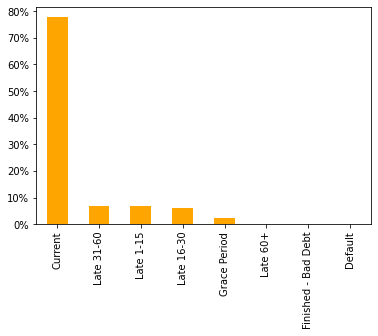

In [11]:
# df.groupby('loan_status').size().plot.bar()
ax = dfnew['Loan_Status'].value_counts(normalize=True).plot.bar(color='orange')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))  
# plt.grid(False)

In [12]:
#Assign 1 or 0 to good and bad loans 
dfnew['rating'] = np.where((dfnew.Loan_Status != 'Late 16-30') & (dfnew.Loan_Status != 'Current') & (dfnew.Loan_Status != 'Late 1-15') & (dfnew.Loan_Status != 'Grace Period'), 1, 0)
pd.value_counts(dfnew.rating).to_frame()

,rating
0,1365372
1,101716


In [13]:
print ('Bad Loan Ratio: %.2f%%'  % (dfnew.rating.sum()/len(dfnew)*100))

Bad Loan Ratio: 6.93%


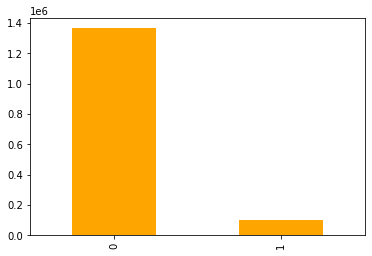

In [14]:
dfnew['rating'].value_counts().plot.bar(color='orange')
plt.savefig('graphProsper.pdf')  


In [15]:
#One hot encode Buyback
one_hot = pd.get_dummies(dfnew['Loan Originator Status'])
# Drop column Buyback Reason as it is now encoded
dfnew = dfnew.drop('Loan Originator Status',axis = 1)
dfnew = dfnew.join(one_hot)

In [16]:
#One-hot encode Loan Originator RUSSIA
one_hot = pd.get_dummies(dfnew['Loan Type'])
# Drop column Loan Originator as it is now encoded
dfnew = dfnew.drop('Loan Type',axis = 1)
dfnew = dfnew.join(one_hot)

# Create subsets of two regions

In [17]:
dfnew.Country.value_counts()

Russian Federation    23620519
Kazakhstan            13514189
Poland                 7685245
Kenya                  6769282
Moldova                5393909
Albania                5174382
Spain                  5051861
Latvia                 3549393
Estonia                2132847
North Macedonia        2048860
Indonesia              1001936
Ukraine                1001201
Mexico                  961420
Colombia                911053
Bulgaria                869929
Namibia                 767988
Romania                 727974
Denmark                 708964
Botswana                637731
United Kingdom          497503
Lithuania               491563
Georgia                 381038
Vietnam                 350783
Zambia                  343815
South Africa            251813
Belarus                 248671
Finland                 232611
Turkey                  112638
Armenia                  45124
Czech Republic           16166
Philippines                216
Name: Country, dtype: int64

In [18]:
#Subset: Russia
df_russia = dfnew.loc[dfnew['Country'] == 'Russian Federation']
# df_russia.head()
# df_russia['Loan Status'].value_counts()

In [19]:
#Subset: Ukraine
df_ukraine = dfnew.loc[dfnew['Country'] == 'Czech Republic']
# df_ukraine.head()
# df_ukraine['Loan Status'].value_counts()

In [20]:
df_ukraine.dtypes

Country                   object
Issue Date                object
Mintos Risk Score         object
Extendable schedule       object
Remaining Loan Amount    float64
In Recovery               object
Loan Rate Percent        float64
Initial Loan Amount      float64
Currency                  object
Term                       int64
Initial LTV                int64
Collateral                object
Loan_Status               object
rating                     int64
Active                     uint8
Defaulted                  uint8
Suspended                  uint8
Agricultural Loan          uint8
Business Loan              uint8
Car Loan                   uint8
Forward Flow               uint8
Invoice Financing          uint8
Mortgage Loan              uint8
Pawnbroking Loan           uint8
Personal Loan              uint8
Short-Term Loan            uint8
dtype: object

In [21]:
#Clean Date Credit Pulled
df_russia["Issue Date"] = pd.to_datetime(df_russia["Issue Date"])
df_russia['Issue Date'] = df_russia['Issue Date'].dt.year
df_russia['Issue Date'].sort_values()
df_russia['Issue Date'].value_counts().sort_index()
year_dict = {2005: 0, 2006: 1, 2007: 2,2008:3, 2009: 4, 2010:5, 2011:6, 2012:7, 2013:8, 2014:9, 2015:10, 2016:11, 2017:12, 2018:13, 2019:14, 2020:15, 2021: 16}
df_russia['Issue Date'] = df_russia['Issue Date'].map(year_dict)
df_russia['Issue Date']

df_ukraine["Issue Date"] = pd.to_datetime(df_ukraine["Issue Date"])
df_ukraine['Issue Date'] = df_ukraine['Issue Date'].dt.year
df_ukraine['Issue Date'].sort_values()
df_ukraine['Issue Date'].value_counts().sort_index()
year_dict = {2005: 0, 2006: 1, 2007: 2,2008:3, 2009: 4, 2010:5, 2011:6, 2012:7, 2013:8, 2014:9, 2015:10, 2016:11, 2017:12, 2018:13, 2019:14, 2020:15, 2021: 16}
df_ukraine['Issue Date'] = df_ukraine['Issue Date'].map(year_dict)
df_ukraine['Issue Date']

934       16
934       16
934       16
934       16
934       16
          ..
498736    16
498736    16
498736    16
498736    16
498736    16
Name: Issue Date, Length: 16166, dtype: int64

In [22]:
pd.set_option('display.max_columns', None) 

# Add columns of one hot encoded loan originators to make columns resemble

In [23]:
dfnew.Country.value_counts()

Russian Federation    23620519
Kazakhstan            13514189
Poland                 7685245
Kenya                  6769282
Moldova                5393909
Albania                5174382
Spain                  5051861
Latvia                 3549393
Estonia                2132847
North Macedonia        2048860
Indonesia              1001936
Ukraine                1001201
Mexico                  961420
Colombia                911053
Bulgaria                869929
Namibia                 767988
Romania                 727974
Denmark                 708964
Botswana                637731
United Kingdom          497503
Lithuania               491563
Georgia                 381038
Vietnam                 350783
Zambia                  343815
South Africa            251813
Belarus                 248671
Finland                 232611
Turkey                  112638
Armenia                  45124
Czech Republic           16166
Philippines                216
Name: Country, dtype: int64

In [24]:
print(df_russia.columns)
print(df_ukraine.columns)

Index(['Country', 'Issue Date', 'Mintos Risk Score', 'Extendable schedule',
       'Remaining Loan Amount', 'In Recovery', 'Loan Rate Percent',
       'Initial Loan Amount', 'Currency', 'Term', 'Initial LTV', 'Collateral',
       'Loan_Status', 'rating', 'Active', 'Defaulted', 'Suspended',
       'Agricultural Loan', 'Business Loan', 'Car Loan', 'Forward Flow',
       'Invoice Financing', 'Mortgage Loan', 'Pawnbroking Loan',
       'Personal Loan', 'Short-Term Loan'],
      dtype='object')
Index(['Country', 'Issue Date', 'Mintos Risk Score', 'Extendable schedule',
       'Remaining Loan Amount', 'In Recovery', 'Loan Rate Percent',
       'Initial Loan Amount', 'Currency', 'Term', 'Initial LTV', 'Collateral',
       'Loan_Status', 'rating', 'Active', 'Defaulted', 'Suspended',
       'Agricultural Loan', 'Business Loan', 'Car Loan', 'Forward Flow',
       'Invoice Financing', 'Mortgage Loan', 'Pawnbroking Loan',
       'Personal Loan', 'Short-Term Loan'],
      dtype='object')


# Process 'object' columns

In [25]:
df_russia = df_russia.drop(['Loan_Status'], axis = 1)
df_ukraine = df_ukraine.drop(['Loan_Status'], axis = 1)

In [26]:
#Clean: Extendable schedule
d = {'No': 0, 'Yes': 1}
df_russia['Extendable schedule'] = df_russia['Extendable schedule'].map(d).fillna(df_russia['Extendable schedule'])
df_ukraine['Extendable schedule'] = df_ukraine['Extendable schedule'].map(d).fillna(df_ukraine['Extendable schedule'])

In [27]:
#Change collateral to dummy Russia
d = {'No': 0, 'Yes': 1}
df_russia['Collateral'] = df_russia['Collateral'].map(d).fillna(df_russia['Collateral'])
df_russia

,Country,Issue Date,Mintos Risk Score,Extendable schedule,Remaining Loan Amount,In Recovery,Loan Rate Percent,Initial Loan Amount,Currency,Term,Initial LTV,Collateral,rating,Active,Defaulted,Suspended,Agricultural Loan,Business Loan,Car Loan,Forward Flow,Invoice Financing,Mortgage Loan,Pawnbroking Loan,Personal Loan,Short-Term Loan
0,Russian Federation,16,7,1,502.29,No,11.5,502.29,EUR,12,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
0,Russian Federation,16,7,1,502.29,No,11.5,502.29,EUR,12,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
0,Russian Federation,16,7,1,502.29,No,11.5,502.29,EUR,12,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
0,Russian Federation,16,7,1,502.29,No,11.5,502.29,EUR,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
0,Russian Federation,16,7,1,502.29,No,11.5,502.29,EUR,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499975,Russian Federation,16,7,1,53.10,No,13.0,64.90,EUR,11,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
499975,Russian Federation,16,7,1,53.10,No,13.0,64.90,EUR,11,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
499975,Russian Federation,16,7,1,53.10,No,13.0,64.90,EUR,11,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
499975,Russian Federation,16,7,1,53.10,No,13.0,64.90,EUR,11,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [28]:
#Change collateral to dummy Ukraine
d = {'No': 0, 'Yes': 1}
df_ukraine['Collateral'] = df_ukraine['Collateral'].map(d).fillna(df_ukraine['Collateral'])
df_ukraine

,Country,Issue Date,Mintos Risk Score,Extendable schedule,Remaining Loan Amount,In Recovery,Loan Rate Percent,Initial Loan Amount,Currency,Term,Initial LTV,Collateral,rating,Active,Defaulted,Suspended,Agricultural Loan,Business Loan,Car Loan,Forward Flow,Invoice Financing,Mortgage Loan,Pawnbroking Loan,Personal Loan,Short-Term Loan
934,Czech Republic,16,7,1,11907.24,No,6.0,11907.24,CZK,2,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
934,Czech Republic,16,7,1,11907.24,No,6.0,11907.24,CZK,2,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
934,Czech Republic,16,7,1,11907.24,No,6.0,11907.24,CZK,2,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
934,Czech Republic,16,7,1,11907.24,No,6.0,11907.24,CZK,2,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
934,Czech Republic,16,7,1,11907.24,No,6.0,11907.24,CZK,2,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498736,Czech Republic,16,7,1,14925.37,No,6.0,14925.37,CZK,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
498736,Czech Republic,16,7,1,14925.37,No,6.0,14925.37,CZK,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
498736,Czech Republic,16,7,1,14925.37,No,6.0,14925.37,CZK,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
498736,Czech Republic,16,7,1,14925.37,No,6.0,14925.37,CZK,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [29]:
# Drop currencies from both the DF's
df_russia = df_russia.drop(['Currency'], axis= 1)
df_ukraine = df_ukraine.drop(['Currency'], axis =1)
# print(df_ukraine.head())
# print(df_russia.head())

In [30]:
df_ukraine['Mintos Risk Score'].value_counts()

7    8227
7    6862
6     888
6     189
Name: Mintos Risk Score, dtype: int64

In [31]:
# Drop countries from both the DF's
df_russia = df_russia.drop(['Country'], axis =1)
df_ukraine = df_ukraine.drop(['Country'], axis=1)
# print(df_ukraine.head())
# print(df_russia.head())

In [32]:
df_ukraine['Mintos Risk Score'] = pd.to_numeric(df_ukraine['Mintos Risk Score'], downcast="float")
df_russia['Mintos Risk Score'] = pd.to_numeric(df_russia['Mintos Risk Score'], downcast="float")

In [33]:
df_russia.dtypes

Issue Date                 int64
Mintos Risk Score        float32
Extendable schedule        int64
Remaining Loan Amount    float64
In Recovery               object
Loan Rate Percent        float64
Initial Loan Amount      float64
Term                       int64
Initial LTV                int64
Collateral                 int64
rating                     int64
Active                     uint8
Defaulted                  uint8
Suspended                  uint8
Agricultural Loan          uint8
Business Loan              uint8
Car Loan                   uint8
Forward Flow               uint8
Invoice Financing          uint8
Mortgage Loan              uint8
Pawnbroking Loan           uint8
Personal Loan              uint8
Short-Term Loan            uint8
dtype: object

In [34]:
#Clean IN RECOVERY 
df_russia = df_russia.drop(['In Recovery'], axis= 1)
df_ukraine = df_ukraine.drop(['In Recovery'], axis =1)

# Fit model of initial dataset 

In [35]:
len(df_ukraine)

16166

In [36]:
#Selecrt fractions of whole dataset
df_russia = df_russia.sample(frac =.1)
# df_ukraine = df_ukraine.sample()

In [37]:
#Split data into X and Y
X = df_russia.loc[:, df_russia.columns != 'rating']
Y = df_russia['rating']

In [38]:
# encode string class values as integers
# label_encoder = LabelEncoder()
# label_encoder = label_encoder.fit(Y)
# label_encoded_y = label_encoder.transform(Y)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [39]:
# fit model no training data
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
print(model)

[15:07:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [40]:
#Split data into X and Y Ukraine
X1 = df_ukraine.loc[:, df_ukraine.columns != 'rating']
Y1 = df_ukraine['rating']

In [41]:
feature_list = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending=False)
print(feature_list)

Mintos Risk Score        0.280020
Term                     0.240436
Loan Rate Percent        0.156140
Issue Date               0.104770
Remaining Loan Amount    0.087674
Initial Loan Amount      0.077905
Pawnbroking Loan         0.014607
Suspended                0.009021
Car Loan                 0.008961
Short-Term Loan          0.008877
Personal Loan            0.005569
Defaulted                0.003287
Active                   0.002733
Collateral               0.000000
Agricultural Loan        0.000000
Business Loan            0.000000
Initial LTV              0.000000
Forward Flow             0.000000
Invoice Financing        0.000000
Mortgage Loan            0.000000
Extendable schedule      0.000000
dtype: float32


In [42]:
# #Reduce model to lower AUC
# for i in range(5):
    
#     seed = 424242
#     test_size = 0.33
#     X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
    
#     model = xgboost.XGBClassifier(**{
#     'learning_rate': 0.075,
#     'max_depth': 5,
#     'min_child_weight': 30,
#     'n_estimators': 130,
#     'reg_lambda': 100,
#     'scale_pos_weight': 1,
#     'subsample': 0.5})
#     model.fit(X_train, y_train)
    
#     #Train TransferBoost model
#     seed = 424242
#     test_size = 0.33
#     X_train_t, X_test_t, y_train_t, y_test_t = model_selection.train_test_split(X1, Y1, test_size=test_size, random_state=seed)
 
    
#     t_xgb_model = XGBTransferLearner(model)

#     t_xgb_model.fit(X_train_t,y_train_t)

#     y_pred_t = t_xgb_model.predict_proba(X_test_t)
#     y_pred_t = [i[1] for i in y_pred_t ]

#     model_standalone = xgboost.XGBClassifier(**{
#     'learning_rate': 0.075,
#     'max_depth': 5,
#     'min_child_weight': 30,
#     'n_estimators': 130,
#     'reg_lambda': 100,
#     'scale_pos_weight': 1,
#     'subsample': 0.5})
    
#     model_standalone.fit(X_train_t, y_train_t)

#     y_pred_st = model_standalone.predict_proba(X_test_t)[:,1]
#     #AUC SCORES XGBoost

#     #Score with transferlearning
#     auc_transferboost = roc_auc_score(y_test_t, y_pred_t)

#     #Score without transferlearning
#     auc_standalone = roc_auc_score(y_test_t, y_pred_st )

#     print("AUC transferboost = ",i, " feature, named", feature_list.index[i], "deleted"  , auc_transferboost)
#     print("AUC standalone = ", i , " feature, named", feature_list.index[i], "deleted"  , auc_standalone)
    
#     X = X.drop([feature_list.index[i]], axis = 1)
#     X1 = X1.drop([feature_list.index[i]], axis = 1)

[15:08:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN: [  829   830   831 ... 16163 16164 16165] TEST: [   0    1    2 ... 1801 1802 1803]
[15:09:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC Initial Model =  0.9470357836738554
AUC transferboost =  0.46149440421329824
AUC standalone =  0.6537820934825543
[15:09:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set 

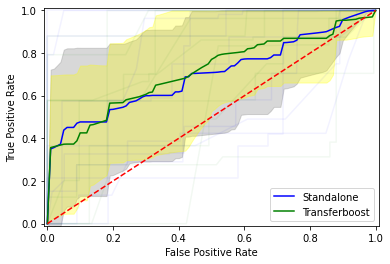

In [43]:
#Train TransferBoost model
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, Y)
skf.get_n_splits(X1, Y1)
list_of_auc_TB = []
list_of_auc_standalone = [] 
list_of_auc_initialmodel = []
tprs = []
base_fpr = np.linspace(0, 1, 101)
tr_tprs = []
tr_base_fpr = np.linspace(0, 1, 101)

for train_index, test_index in skf.split(X1, Y1):
    
    seed = 424242
    test_size = 0.33
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    model = xgboost.XGBClassifier(**{
    'learning_rate': 0.075,
    'max_depth': 5,
    'min_child_weight': 30,
    'n_estimators': 130,
    'reg_lambda': 100,
    'scale_pos_weight': 1,
    'subsample': 0.5})
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]


    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_t, X_test_t = X1.iloc[train_index], X1.iloc[test_index]
    y_train_t, y_test_t = Y1.iloc[train_index], Y1.iloc[test_index]
    
 
    t_xgb_model = XGBTransferLearner(model)

    t_xgb_model.fit(X_train_t,y_train_t)

    y_pred_t = t_xgb_model.predict_proba(X_test_t)
    y_pred_t = [i[1] for i in y_pred_t ]

    model_standalone = xgboost.XGBClassifier(**{
        'learning_rate': 0.075,
        'max_depth': 5,
        'min_child_weight': 30,
        'n_estimators': 130,
        'reg_lambda': 100,
        'scale_pos_weight': 1,
        'subsample': 0.5})
    
    model_standalone.fit(X_train_t, y_train_t)
    
    y_pred_st = model_standalone.predict_proba(X_test_t)[:,1]
    
    #AUC SCORES XGBoost
    #Score with initial model
    auc_inputmodel = roc_auc_score(y_test, y_pred)

    #Score with transferlearning
    auc_transferboost = roc_auc_score(y_test_t, y_pred_t)

    #Score without transferlearning
    auc_standalone = roc_auc_score(y_test_t, y_pred_st)
    
    print("AUC Initial Model = ", auc_inputmodel)
    list_of_auc_initialmodel.append(auc_inputmodel) 
    print("AUC transferboost = ", auc_transferboost)
    list_of_auc_TB.append(auc_transferboost)
    print("AUC standalone = ", auc_standalone)
    list_of_auc_standalone.append(auc_standalone)
    
    fpr, tpr, _ = roc_curve(y_test_t, y_pred_st)
    tr_fpr, tr_tpr, _ = roc_curve(y_test_t, y_pred_t)
    
    plt.plot(fpr, tpr, 'b', alpha=0.05)
    plt.plot(tr_fpr, tr_tpr, 'g', alpha=0.05)
    
    tpr = interp(base_fpr, fpr, tpr)
    tr_tpr = interp(tr_base_fpr, tr_fpr, tr_tpr)
    
    tpr[0] = 0.0
    tr_tpr[0] = 0.0
    
    tr_tprs.append(tr_tpr)
    tprs.append(tpr)
    
    
print("Mean AUC Initial:", sum(list_of_auc_initialmodel) / len(list_of_auc_initialmodel), "Std Dev TB:", statistics.stdev(list_of_auc_initialmodel))         
print("Mean AUC TB:", sum(list_of_auc_TB) / len(list_of_auc_TB), "Std Dev TB:", statistics.stdev(list_of_auc_TB))
print("Mean AUC Standalone:", sum(list_of_auc_standalone) / len(list_of_auc_standalone), "Std Dev Standalone:", statistics.stdev(list_of_auc_standalone))

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

tr_tprs = np.array(tr_tprs)
mean_tr_tprs = tr_tprs.mean(axis=0)
tr_std = tr_tprs.std(axis=0)

tr_tprs_upper = np.minimum(mean_tr_tprs + tr_std, 1)
tr_tprs_lower = mean_tr_tprs - tr_std


plt.plot(base_fpr, mean_tprs, 'b', label='Standalone')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot(tr_base_fpr, mean_tr_tprs, 'g', label='Transferboost')
plt.fill_between(tr_base_fpr, tr_tprs_lower, tr_tprs_upper, color='yellow', alpha=0.3)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
pyplot.legend()
# plt.axes().set_aspect('equal', 'datalim')
plt.show()